**Terraformers Data Platform Data Queries**

First, we form a connection to the OLAP Data Warehouse. The wh_connection function accesses AWS Secrets Manager to retrieve the securely held Database credentials, then connects to the DB.

In [200]:
from lambda3.src.lambda3_connection import wh_connection
from decimal import Decimal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

conn = wh_connection()

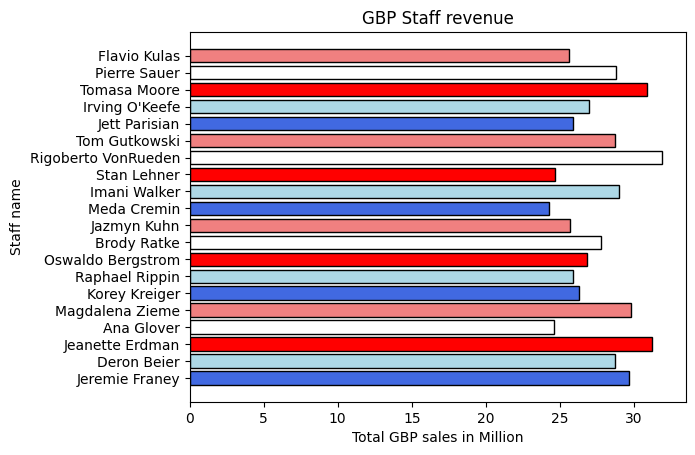

In [138]:
sales_gbp_by_staff_rows = conn.run("""SELECT ROUND((SUM(units_sold * unit_price)/1000000), 1)
                       AS total_mil_gbp_sold, CONCAT (first_name, ' ', last_name) AS staff_name
                       FROM fact_sales_order 
                       JOIN dim_staff
                       ON staff_id = sales_staff_id
                       JOIN dim_currency
                       ON fact_sales_order.currency_id = dim_currency.currency_id
                       WHERE dim_currency.currency_code = 'GBP'
                       GROUP BY staff_id, dim_currency.currency_code;""")
fsales_cols = [col['name'] for col in conn.columns]
gbp_df = pd.DataFrame(sales_gbp_by_staff_rows, columns=fsales_cols)
plt.barh(gbp_df['staff_name'], gbp_df['total_mil_gbp_sold'], color=['royalblue', 'lightblue','red', 'white', 'lightcoral'], edgecolor='black')
plt.xlabel("Total GBP sales in Million")
plt.ylabel("Staff name")
plt.title("GBP Staff revenue")
plt.show()



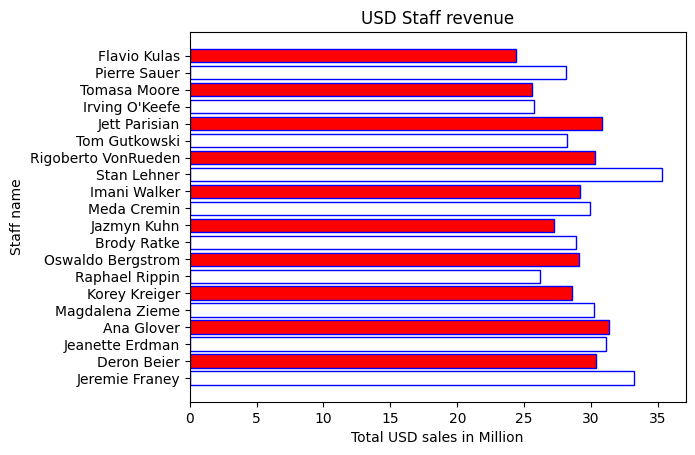

In [141]:
sales_usd_by_staff_rows = conn.run("""SELECT ROUND((SUM(units_sold * unit_price)/1000000), 1)
                       AS total_mil_usd_sold, CONCAT (first_name, ' ', last_name) AS staff_name
                       FROM fact_sales_order 
                       JOIN dim_staff
                       ON staff_id = sales_staff_id
                       JOIN dim_currency
                       ON fact_sales_order.currency_id = dim_currency.currency_id
                       WHERE dim_currency.currency_code = 'USD'
                       GROUP BY staff_id, dim_currency.currency_code;""")
fsales_cols = [col['name'] for col in conn.columns]
usd_df = pd.DataFrame(sales_usd_by_staff_rows, columns=fsales_cols)
plt.barh(usd_df['staff_name'], usd_df['total_mil_usd_sold'], color=['white', 'red'], edgecolor=['blue'])
plt.xlabel("Total USD sales in Million")
plt.ylabel("Staff name")
plt.title("USD Staff revenue")
plt.show()

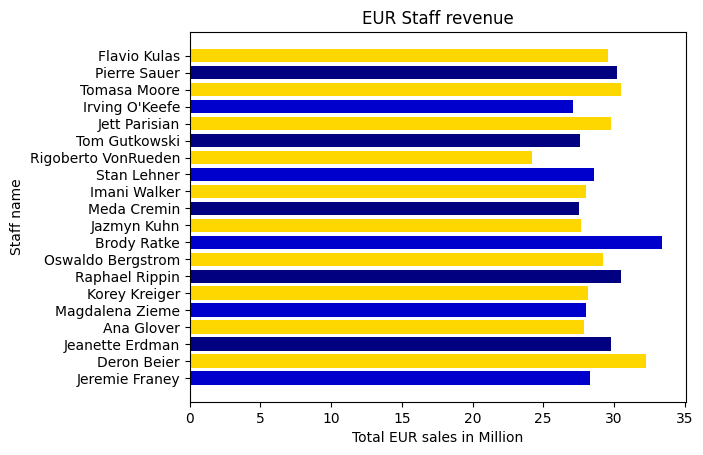

In [136]:
sales_eur_by_staff_rows = conn.run("""SELECT ROUND((SUM(units_sold * unit_price)/1000000), 1)
                       AS total_mil_eur_sold, CONCAT (first_name, ' ', last_name) AS staff_name
                       FROM fact_sales_order 
                       JOIN dim_staff
                       ON staff_id = sales_staff_id
                       JOIN dim_currency
                       ON fact_sales_order.currency_id = dim_currency.currency_id
                       WHERE dim_currency.currency_code = 'EUR'
                       GROUP BY staff_id, dim_currency.currency_code;""")
fsales_cols = [col['name'] for col in conn.columns]
eur_df = pd.DataFrame(sales_eur_by_staff_rows, columns=fsales_cols)
plt.barh(eur_df['staff_name'], eur_df['total_mil_eur_sold'], color=['mediumblue', 'gold','navy', 'gold'])
plt.xlabel("Total EUR sales in Million")
plt.ylabel("Staff name")
plt.title("EUR Staff revenue")
plt.show()

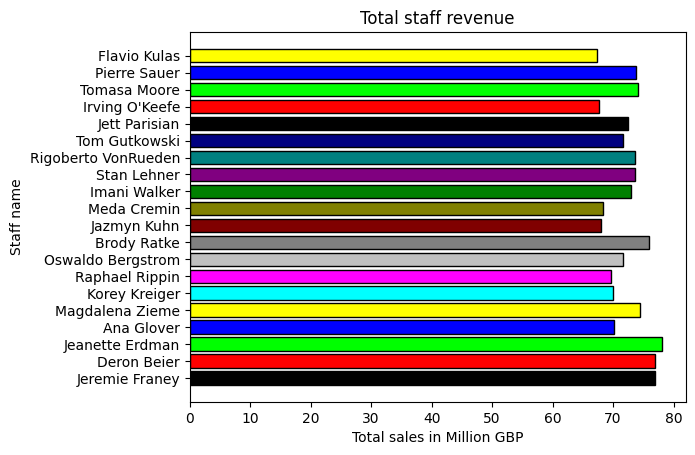

In [145]:
merged = gbp_df.merge(usd_df, how='inner', on='staff_name')
eur_merged = merged.merge(eur_df, how='inner', on='staff_name')
eur_merged['usd_in_gbp'] = eur_merged['total_mil_usd_sold'] * Decimal(0.74)
eur_merged['eur_in_gbp'] = eur_merged['total_mil_eur_sold'] * Decimal(0.8)
eur_merged['total_sold_all_currencies_into_gbp'] = eur_merged['usd_in_gbp'] + eur_merged['total_mil_gbp_sold'] + eur_merged['eur_in_gbp']
eur_merged['total_sold'] = eur_merged['total_sold_all_currencies_into_gbp'].astype('float').round(1)
final_df = eur_merged[['staff_name', 'total_sold']]
plt.barh(final_df['staff_name'], final_df['total_sold'], color=list({
    'Black': (0, 0, 0),
    'Red': (255, 0, 0),
    'Lime': (0, 255, 0),
    'Blue': (0, 0, 255),
    'Yellow': (255 ,255, 0),
    'Cyan': (0, 255, 255),
    'Fuchsia': (255, 0, 255),
    'Silver': (192, 192, 192),
    'Gray': (128, 128, 128),
    'Maroon': (128, 0, 0),
    'Olive': (128, 128, 0),
    'Green': (0, 128, 0),
    'Purple': (128, 0, 128),
    'Teal': (0, 128, 128),
    'Navy': (0, 0, 128),
}.keys()), edgecolor='black')
plt.xlabel("Total sales in Million GBP")
plt.ylabel("Staff name")
plt.title("Total staff revenue")
plt.show()








In [152]:
final_df.loc[final_df['total_sold'].idxmax()]

staff_name    Jeanette Erdman
total_sold               78.1
Name: 2, dtype: object

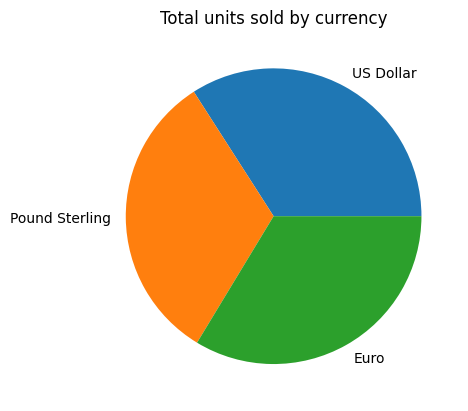

In [ ]:
currency_rows = conn.run("""SELECT SUM(units_sold) AS total_units_sold,
                         currency_name
                         FROM dim_currency
                         JOIN fact_sales_order
                         ON fact_sales_order.currency_id = dim_currency.currency_id
                         GROUP BY currency_name;""")
currency_cols = [col['name'] for col in conn.columns]
currency_df = pd.DataFrame(currency_rows, columns=currency_cols)
currency_df
plt.pie(currency_df['total_units_sold'], labels=currency_df['currency_name'])
plt.title("Total units sold by currency")
plt.show()

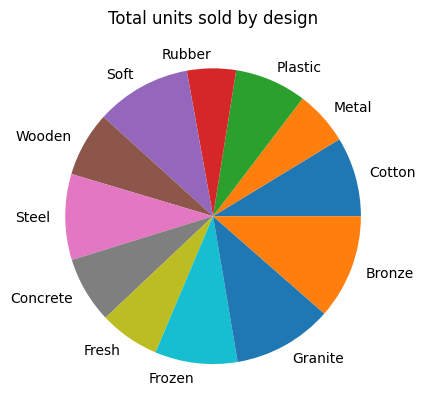

In [162]:
design_rows = conn.run("""SELECT SUM(units_sold) AS total_units_sold,
                         design_name
                         FROM dim_design
                         JOIN fact_sales_order
                         ON fact_sales_order.design_id = dim_design.design_id
                         GROUP BY design_name;""")
design_cols = [col['name'] for col in conn.columns]
design_df = pd.DataFrame(design_rows, columns=design_cols)
design_df
plt.pie(design_df['total_units_sold'], labels=design_df['design_name'])
plt.title("Total units sold by design")
plt.show()

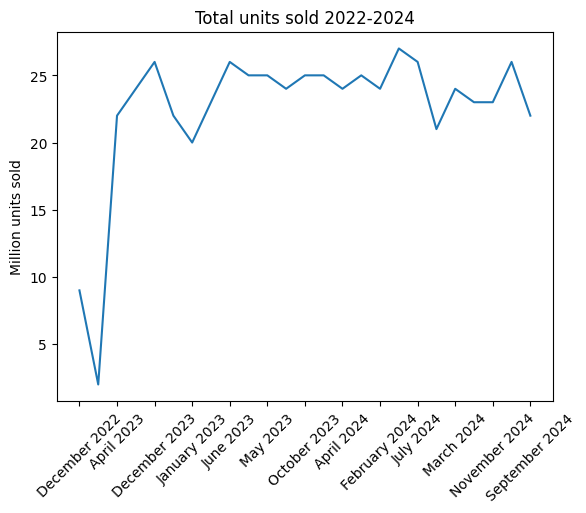

In [216]:
time_rows = conn.run("""SELECT SUM(units_sold)/1000000 AS mil_units_sold,
                         CONCAT(month_name, ' ', year) AS month
                         FROM dim_date
                         JOIN fact_sales_order
                         ON fact_sales_order.created_date = dim_date.date_id
                         GROUP BY month, month_name, year
                     ORDER BY year, month;""")
time_cols = [col['name'] for col in conn.columns]
time_df = pd.DataFrame(time_rows, columns=time_cols)
plt.plot(time_df['month'], time_df['mil_units_sold'])
plt.xticks(ticks=list(range(0,len(time_df), 2)), rotation=45)
plt.title("Total units sold 2022-2024")
plt.ylabel("Million units sold")
plt.show()

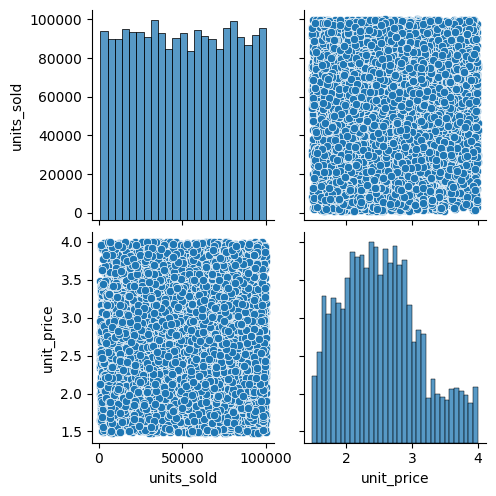

In [274]:
unit_rows = conn.run("""SELECT units_sold,
                     CASE WHEN
                     currency_code = 'USD'
                     THEN unit_price * 0.74
                     WHEN currency_code = 'EUR'
                     THEN unit_price * 0.8
                     ELSE unit_price END unit_price
                         FROM fact_sales_order
                     JOIN dim_currency
                     ON dim_currency.currency_id = fact_sales_order.currency_id
                     ;""")
unit_cols = [col['name'] for col in conn.columns]
unit_df = pd.DataFrame(unit_rows, columns=unit_cols)
unit_df
sns.pairplot(data=unit_df, kind='scatter')
plt.show()

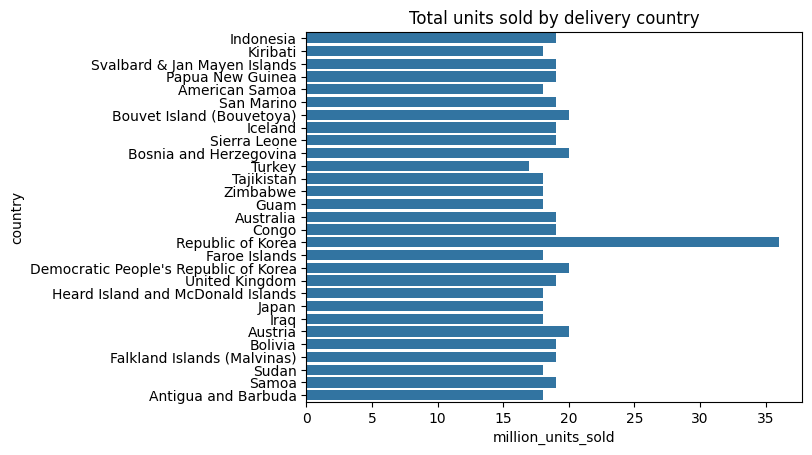

In [307]:
deliv_rows = conn.run("""SELECT SUM(units_sold)/1000000 AS million_units_sold, country
                         FROM fact_sales_order
                     JOIN dim_location
                     ON location_id = agreed_delivery_location_id
                     GROUP BY country
                     ;""")
deliv_cols = [col['name'] for col in conn.columns]
deliv_df = pd.DataFrame(deliv_rows, columns=deliv_cols)
sns.barplot(data=deliv_df, x=deliv_df['million_units_sold'], y=deliv_df['country'])
plt.title("Total units sold by delivery country")
plt.show()

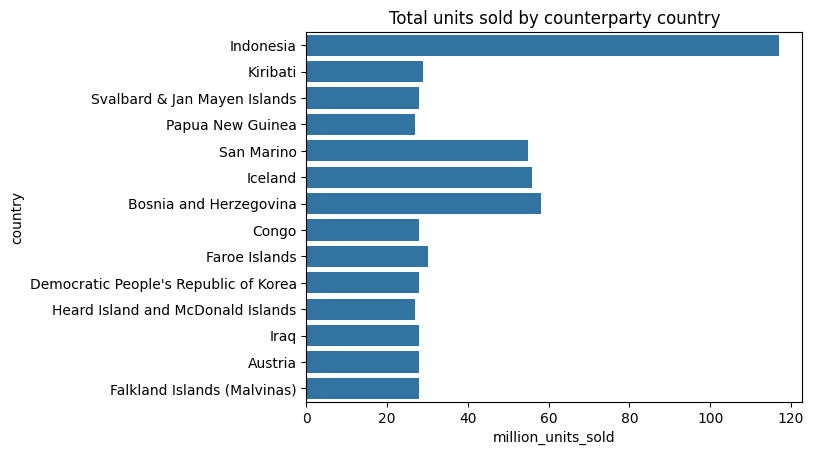

In [308]:
counter_rows = conn.run("""SELECT SUM(units_sold)/1000000 AS million_units_sold, counterparty_legal_country AS country
                         FROM fact_sales_order
                     JOIN dim_counterparty
                     ON fact_sales_order.counterparty_id = dim_counterparty.counterparty_id
                     GROUP BY counterparty_legal_country
                     ;""")
counter_cols = [col['name'] for col in conn.columns]
counter_df = pd.DataFrame(counter_rows, columns=counter_cols)
sns.barplot(data=counter_df, x=counter_df['million_units_sold'], y=counter_df['country'])
plt.title("Total units sold by counterparty country")
plt.show()

<Axes: title={'center': 'Million units sold by country'}, ylabel='country'>

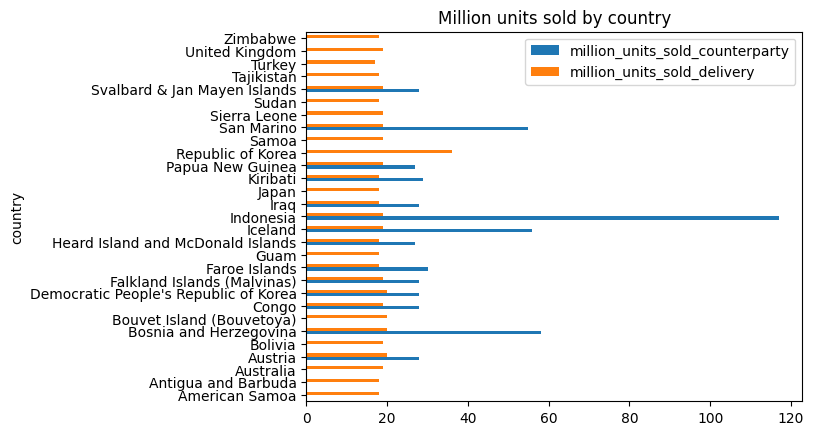

In [331]:
# plt.barh(deliv_df['country'], deliv_df['million_units_sold'])
# plt.barh(counter_df['country'], counter_df['million_units_sold'])
# plt.show()
location_df = counter_df.merge(deliv_df, how='outer', on='country')
location_df.rename(columns={'million_units_sold_x':'million_units_sold_counterparty', 'million_units_sold_y': 'million_units_sold_delivery'}, inplace=True)
schema = ['country', 'million_units_sold_counterparty', 'million_units_sold_delivery']
# sns.barplot(data=location_df['million_units_sold_counterparty'], y=location_df['country'])
location_df = location_df[schema]
location_df.plot(y=['million_units_sold_counterparty', 'million_units_sold_delivery'], x='country', kind='barh', title='Million units sold by country')
